# rl5E_lite_from_cfg.ipynb

This notebook contains the fifth step in the 5-step process outlined in November 13th, 2020, in order to produce an actor-critic architecture for pendulum control. 

In step 1 we create a network with N units that takes the activity of 1 unit and transforms it into a bell-shaped representation.  
In step 2 we put 2 of those as the inputs to a (N/2)x(N/2) grid, and visualized.  
In step 3 we took the network from step 2 and connected it to the current SP and SD units in `test3p2` to see if the angle is being tracked.  
In step 4 we will connect a $V$ neuron to the L (RBF) layer, and tweak TD learning so its output starts to reflect the angular error.  
In step 5 the output of $V$ is used to configure a controller. There are three basic options outlined in the November 20th, 2020 entry of the log, and a fourth option in Nov. 30th. This fifth option was introduced in December 1st, 2020.

In this "lite" version the L layer, and the L__V, L__X synapses are substituded by two multidimensional units (see Jan 4, 2021 log).

In [1]:
%cd /home/z/projects/draculab/
# Move to the draculab home folder

/home/z/projects/draculab


In [2]:
from draculab import *
import numpy as np
import matplotlib.pyplot as plt
import time
from tools.visualization import plotter
import pickle

In [3]:
ranges = {"C_sigma": {"low": 0.01, "high": 1., "default": 0.4 }, # yes
          "C_slope": {"low": 1., "high": 3., "default": 2. },
          "C_thresh": {"low": 0.0, "high": .2, "default":0.2},
          "C_integ_amp": {"low": 0.0, "high": 1.5, "default": 0.0},
          "C_custom_inp_del": {"low": 10, "high": 300, "default": 150}, # seemingly replaced in the code
          "M_des_out_w_abs_sum": {"low": 0.5, "high": 3., "default":1.6},
          "P_mu": {"low": .1, "high": 2., "default":1.},
          "P_inp_gain": {"low": 0.5, "high": 4., "default":2.},
          "SF_slope": {'low':0.5, "high":3., "default":2.},
          "V_slope": {"low": 0.3, "high": 2.5, "default":1.5}, #yes
          "V_delta": {"low": .2, "high": 4., "default":1.}, #yes
          "V_thresh": {"low": -0.1, "high": 2., "default":0.}, # no
          "V_td_lrate": {"low": 0.2, "high": 7., "default": 1.5}, # yes
          "V_td_gamma": {"low": 0.1, "high": .95, "default": .6}, # yes
          "V_w_sum": {"low": 10., "high": 100., "default": 60.}, # yes
          "X_slope": {"low": 2., "high": 10., "default":5.}, #yes
          "X_thresh": {"low": -0.2, "high": 2., "default":1.}, # no
          "X_del": {"low": 0., "high": 1.5, "default":0.3},
          "X_l_rate": {"low": 50., "high": 400., "default":200.},
          "X_w_sum": {"low": 10., "high": 80., "default": 30.}, # yes
          "X_refr_per": {"low": 0.5, "high": 4., "default":2.}, # yes
          "A__M_lrate": {"low": 0.05, "high": 10., "default":5.},
          "A__M_w_sum": {"low": 0.3, "high": 2., "default":.4},
          "A__M_w_max": {"low": 0.2, "high": .4, "default":.3},
          "M__C_lrate": {"low": 1., "high": 400., "default":100.},
         }

cfg = {}
for name in ranges:
    cfg[name] = ranges[name]['default']
    
gene_cfg = {'V_slope': 1.5,
            'V_delta': 2.5,
            'V_td_lrate': 0.3350351863301838, 
            'V_td_gamma': 0.1, 'V_w_sum': 60.0, 
            'X_slope': 5.0, 'X_del': 0.3, 
            'X_lrate': 300.0, 
            'X_w_sum': 55.0, 
            'fitness': 0.2601113238633763, 
            'n_evals': 1, 
            'C_sigma': 0.4, 
            'C_slope': 2.0, 
            'C_thresh': 0.2, 
            'C_integ_amp': 0.0, 
            'C_custom_inp_del': 150, 
            'M_des_out_w_abs_sum': 1.6, 
            'P_mu': 1.0, 
            'P_inp_gain': 2.0, 
            'V_thresh': 0.0, 
            'X_thresh': 0.0, 
            'A__M_lrate': 5.0, 
            'A__M_w_sum': 0.4, 
            'A__M_w_max': 0.3, 
            "SF_slope": 2.,
            'M__C_lrate': 100.0}


In [4]:
# Load the results from a previous run of rl5E_lite_par
# You need to adjust according to the number of repetitions
%cd /home/z/projects/draculab/saves
#%cd /home/sergio/projects/draculab/notebook/spinal/rl
fname = 'rl5E_lite_par_2021-03-16__14_04'
with (open(fname, "rb")) as f:
    res_dict = pickle.load(f)
    f.close()
    
configs = res_dict['configs']
all_results = res_dict['all_results']
#n_reps = 20 # this needs to be adjusted accordingly !!!!!!
#n_configs = int(np.round(len(configs)/n_reps))
cfg = configs[0]

/home/z/projects/draculab/saves


In [40]:
cfg

{'V_slope': 1.5,
 'V_delta': 2.5,
 'V_td_lrate': 0.3350351863301838,
 'V_td_gamma': 0.1,
 'V_w_sum': 60.0,
 'X_slope': 5.0,
 'X_del': 0.3,
 'X_lrate': 300.0,
 'X_w_sum': 55.0,
 'fitness': 0.2601113238633763,
 'n_evals': 1,
 'C_sigma': 0.4,
 'C_slope': 2.0,
 'C_thresh': 0.2,
 'C_integ_amp': 0.0,
 'C_custom_inp_del': 150,
 'M_des_out_w_abs_sum': 1.6,
 'P_mu': 1.0,
 'P_inp_gain': 2.0,
 'V_thresh': 0.0,
 'X_thresh': 1.3,
 'A__M_lrate': 5.0,
 'A__M_w_sum': 0.4,
 'A__M_w_max': 0.3,
 'SF_slope': 2.0,
 'M__C_lrate': 100.0,
 'sim_time1': 2000.0,
 'sim_time2': 500.0,
 'pres_interv': 4.0}

In [5]:
%cd /home/z/projects/draculab/notebook/spinal/rl
# Move to the folder with the rl5E_lite_from_cfg file is
from rl5E_lite_from_cfg import rl5E_net

/home/z/projects/draculab/notebook/spinal/rl


In [6]:
#===================================================================
#================ CREATE THE NETWORK ===============================
#===================================================================
net, pops_dict = rl5E_net(gene_cfg, 
                          pres_interv=cfg['pres_interv'],
                          rand_w=False,
                          par_heter=0.1,
                          x_switch=True,
                          V_normalize=True,
                          X_normalize=True)

for name in pops_dict:
    exec(name + '=' + str(pops_dict[name]))
des_angs = np.array(des_angs)

In [3]:
# Initialize L__V connections
net.units[V[0]].buffer[1:,-1] = np.array([2.*np.pi-abs(c[0]-c[1]) for c in
                                          net.units[V[0]].centers])

In [5]:
net.plants[P].mu = .5
for i in [0,1]:
    for syn in net.syns[C[i]]:
        if syn.type == 'rga_21':
            syn.lrate = 50.
            syn.alpha = syn.lrate * net.min_delay

In [31]:
# Configuring X
net.units[X[0]].switch = False # stop switching
#net.units[X[0]].thresh = 0.

In [32]:
sim_time = 30.
#ratio = 15.1 # cns-amd
ratio = 1.6 # breaker
#ratio = 1.6 # breaker, no L,V
secs2finish = sim_time * ratio
lt1 = time.localtime()
hrs, hrs_rem = divmod(secs2finish, 3600)
mins, mns_rem = divmod(hrs_rem, 60)
xtra_hrs, new_mins = divmod(lt1.tm_min+mins, 60)
print("Expecting to finish at: %d:%d (%d seconds)" % 
      (lt1.tm_hour+hrs+xtra_hrs, new_mins, secs2finish))
start_time = time.time()

times, data, plant_data  = net.run(sim_time)

print('Execution time is %s seconds' % (time.time() - start_time))
lt2 = time.localtime
print("Finished at " + time.strftime('%H:%M'))
data = np.array(data)

# import cProfile
# import pstats
# cProfile.run('times, data, plant_data = net.run(2.)', 'restats')
# prof = pstats.Stats('restats')
# prof.sort_stats('cumulative').print_stats(30)
# data = np.array(data

Expecting to finish at: 11:32 (48 seconds)
Execution time is 49.85028123855591 seconds
Finished at 11:33


In [33]:
# running in two stages. Initial high learning rate and viscosity.
sim_time = 150.
#ratio = 15.1 # cns-amd
#ratio = 20. # breaker
ratio = 1.6 # breaker, no L,V
secs2finish = sim_time * ratio
lt1 = time.localtime()
hrs, hrs_rem = divmod(secs2finish, 3600)
mins, mns_rem = divmod(hrs_rem, 60)
xtra_hrs, new_mins = divmod(lt1.tm_min+mins, 60)
print("Expecting to finish firstst simulation at %d:%d (%d seconds)" % 
      (lt1.tm_hour+hrs+xtra_hrs, new_mins, secs2finish))
start_time = time.time()

times, data, plant_data  = net.run(sim_time)

print('Initial execution time is %s seconds' % (time.time() - start_time))
lt2 = time.localtime
print("Finished at " + time.strftime('%H:%M'))
data = np.array(data)

sim_time = 100.
net.plants[0].mu = 0.5
for i in [0,1]:
    for syn in net.syns[C[i]]:
        if syn.type == 'rga_21':
            syn.lrate = 100.
            syn.alpha = syn.lrate * net.min_delay

secs2finish = sim_time * ratio
lt1 = time.localtime()
hrs, hrs_rem = divmod(secs2finish, 3600)
mins, mns_rem = divmod(hrs_rem, 60)
xtra_hrs, new_mins = divmod(lt1.tm_min+mins, 60)
print("Expecting to finish at: %d:%d (%d seconds)" % 
      (lt1.tm_hour+hrs+xtra_hrs, new_mins, secs2finish))
start_time = time.time()

times, data, plant_data  = net.run(sim_time)

print('Second execution time is %s seconds' % (time.time() - start_time))
lt2 = time.localtime
print("Finished at " + time.strftime('%H:%M'))
data = np.array(data)

Expecting to finish firstst simulation at 17:9 (240 seconds)


KeyboardInterrupt: 

In [18]:
net.units[SP[0]].set_function(lambda t: des_sf[int(round(t/15.))])

In [8]:
# reducing the scope of the plots
data_back = data
times_back = times
plant_data_back = [np.array([])]
plant_data_back[0] = plant_data[0]

first_idx=0*200
second_idx=1*200
times = times[first_idx:second_idx]
data = data[:, first_idx:second_idx]
plant_data[0] = plant_data[0][first_idx:second_idx,:]

In [10]:
# recover the data
data = data_back
plant_data[0] = plant_data_back[0]
times = times_back

Running 2nd generation results from genetic algorithm.
* R = .52 from t=500 to t=4000 (switching X)
* mean R=.612 t=4000 to t=4500 (not switching)
* mean R=.625 t=4500 to t=5000 (not switching)
* mean R=.6 t=5000 to t=5000 (not switching)

MPLEX Error : 0.12173303449227642
Mean reward: 0.2726625273952393


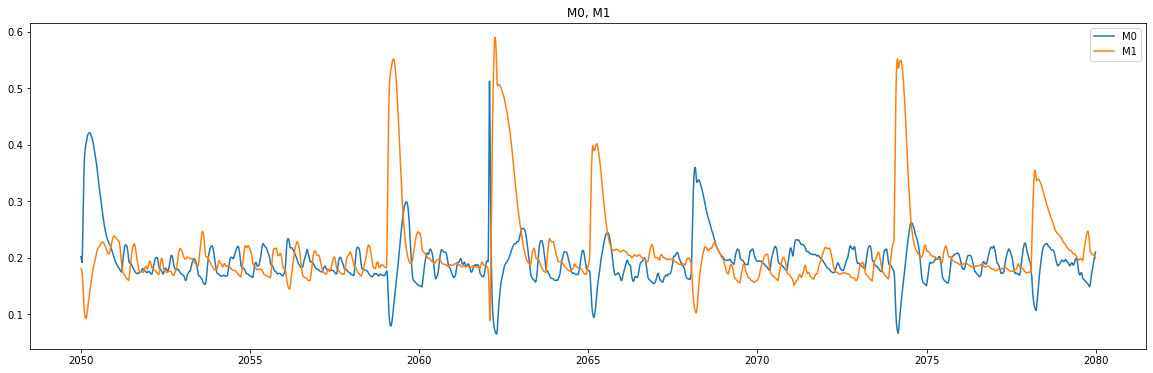

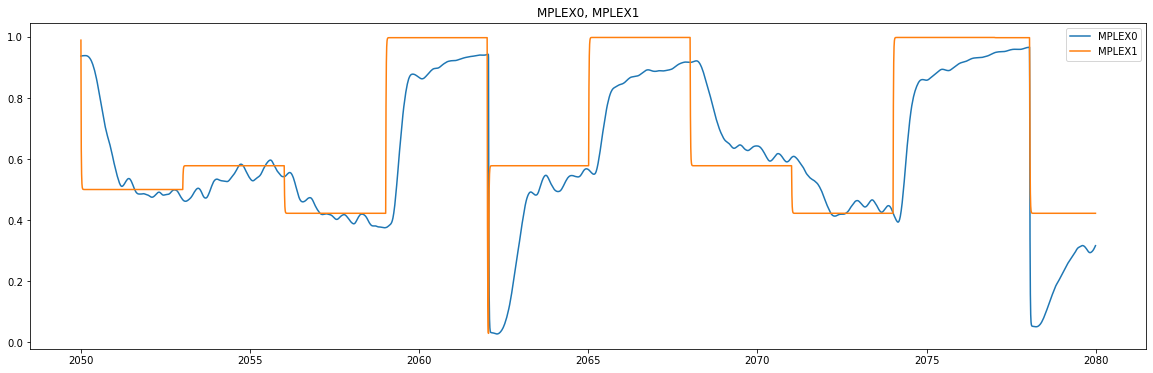

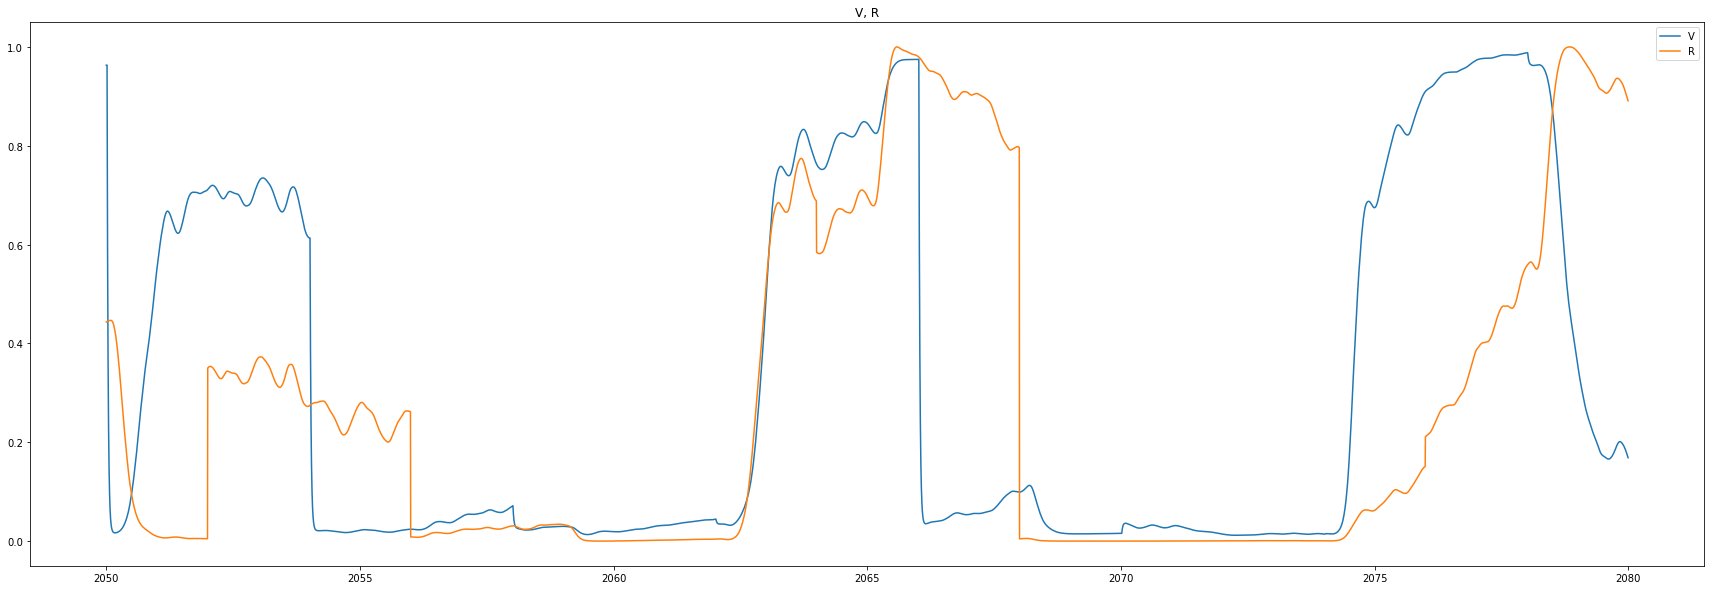

In [41]:
fs = (20,6)

# M
M_fig = plt.figure(figsize=fs)
M_data = np.array(data[M])
plt.plot(times, M_data.transpose())
plt.legend(['M0', 'M1'])
plt.title('M0, M1')
#print(M_data[:,-1])

# MPLEX
MPLEX_fig = plt.figure(figsize=fs) #(30,12))
MPLEX_data = np.array(data[MPLEX])
plt.plot(times, MPLEX_data.transpose())
plt.legend(['MPLEX0', 'MPLEX1'])
plt.title('MPLEX0, MPLEX1')

init_idx = 0 #int((0.5*sim_time)/net.min_delay) # index for last half
MPLEX_error = np.abs(MPLEX_data[0,init_idx:]-MPLEX_data[1,init_idx:]).sum() / (times.size-init_idx)
print("MPLEX Error : " + str(MPLEX_error))

# V, R
V_fig = plt.figure(figsize=(30,10)) #fs)
V_data = np.array(data[V])
R_data = np.array(data[R])
#R = np.exp(-net.units[V[0]].R_wid * np.abs(MPLEX_data[0,:]-MPLEX_data[1,:]))
plt.plot(times, V_data.transpose())
plt.plot(times, R_data.transpose())
plt.title('V, R')
#plt.plot(times, R, linewidth=4)
plt.legend(['V', 'R'])

print("Mean reward: " + str(np.mean(R_data)))

# # M--C0 weights
# W_fig1 = plt.figure(figsize=fs)
# w_track_data = np.array(data[M_C0_track])
# plt.plot(times, w_track_data.transpose())
# plt.legend(['M0-C0', 'M1-C0'])
# plt.title('M--C0 weights')

# # A--M0 weights
# W_fig2 = plt.figure(figsize=fs)
# w_track_data2 = np.array(data[A_M0_track])
# plt.plot(times, w_track_data2.transpose())
# plt.legend(['A0-M0', 'A1-M0', 'A2-M0', 'A3-M0'])
# plt.title('A--M0 weights')

plt.show()

mean angle error : 2.0197217615784506


Text(0.5, 1.0, 'SPF')

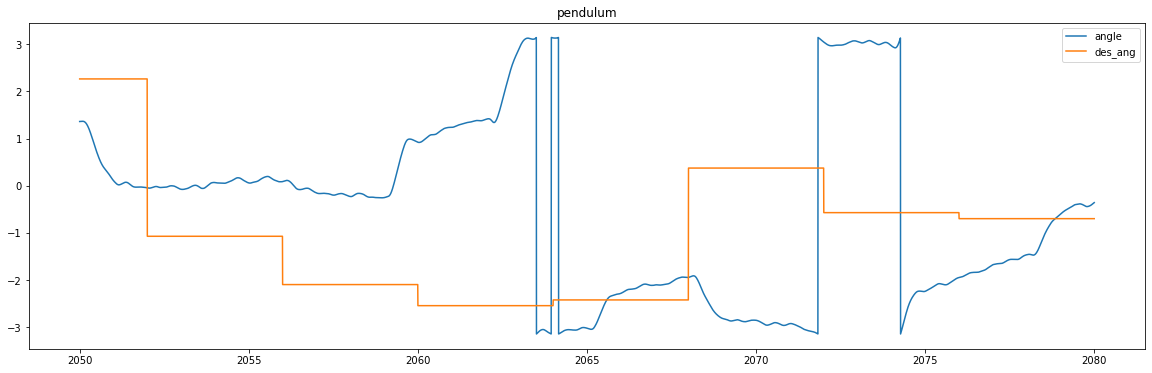

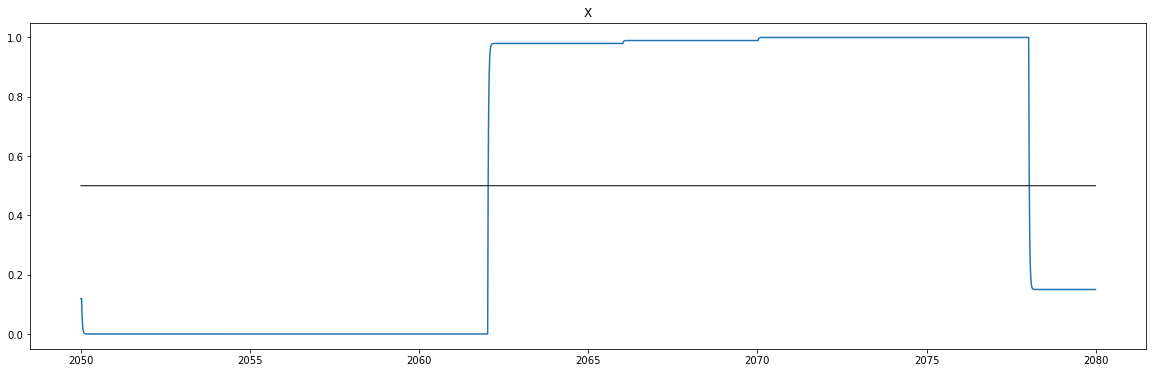

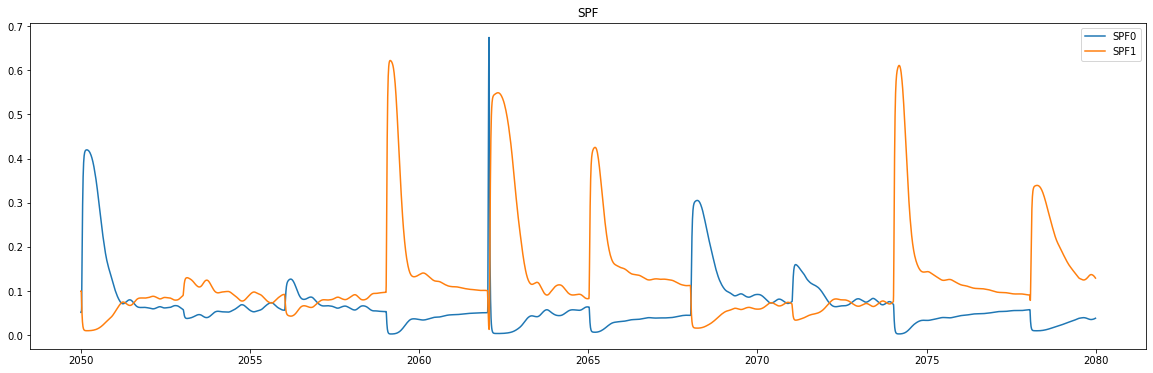

In [34]:
# P, DA
#fs = (40, 10)
pres_interv = cfg['pres_interv']
P_fig = plt.figure(figsize=fs)
P_data = plant_data[P]
plt.plot(times, P_data[:,0], label='angle')
#plt.plot(times, P_data[:,1], label='ang vel')
desa_data = des_angs[(times/pres_interv).astype(int)]
spf = net.units[SP[0]].get_act

plt.plot(times, desa_data, label='des_ang')
plt.legend()
plt.title('pendulum')
#print("angle: %f, vel: %f" % (P_data[-1,0],P_data[-1,1]))

init_idx = 0 #int((0.5*sim_time)/net.min_delay) # index for last 200 seconds
ang_error = np.abs(P_data[:,0]-desa_data).sum() / (times.size-init_idx)
print("mean angle error : " + str(ang_error))


# X
X_fig = plt.figure(figsize=fs)
X_data = np.array(data[X])
plt.plot(times, X_data.transpose())
plt.plot(times, 0.5*np.ones(len(times)), 'k', linewidth=1)
#plt.ylim([-0.05,1.05])
#plt.legend(['X'])
plt.title('X')


# SPF
#fs = (20,6)
SPF_fig = plt.figure(figsize=fs)
SPF_data = np.array(data[SPF])
plt.plot(times, SPF_data.transpose())
plt.legend(['SPF0', 'SPF1'])
plt.title('SPF')

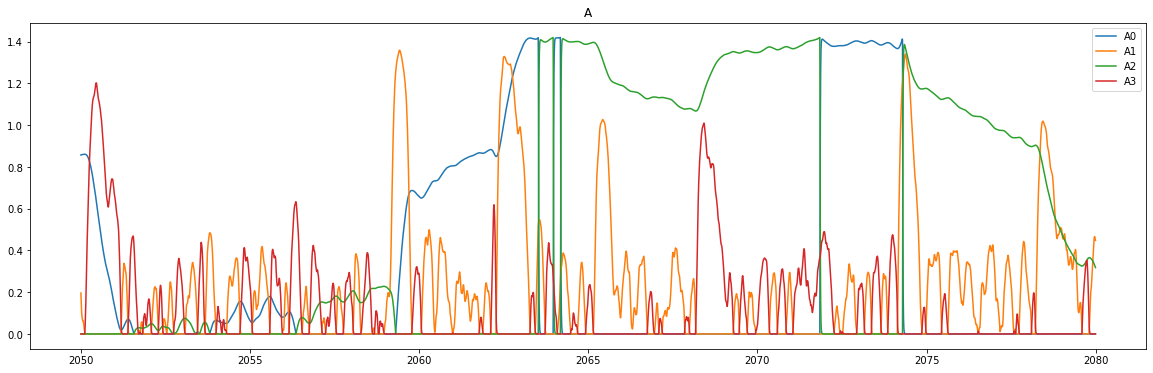

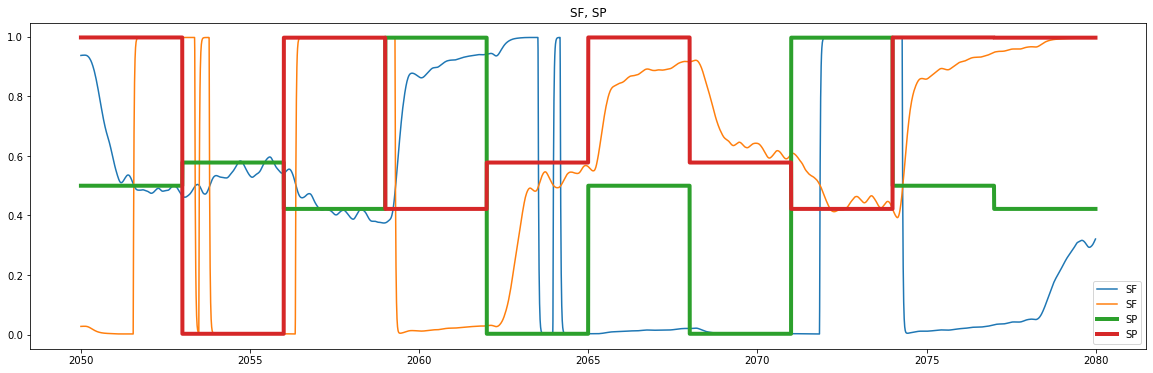

Text(0.5, 1.0, 'C1')

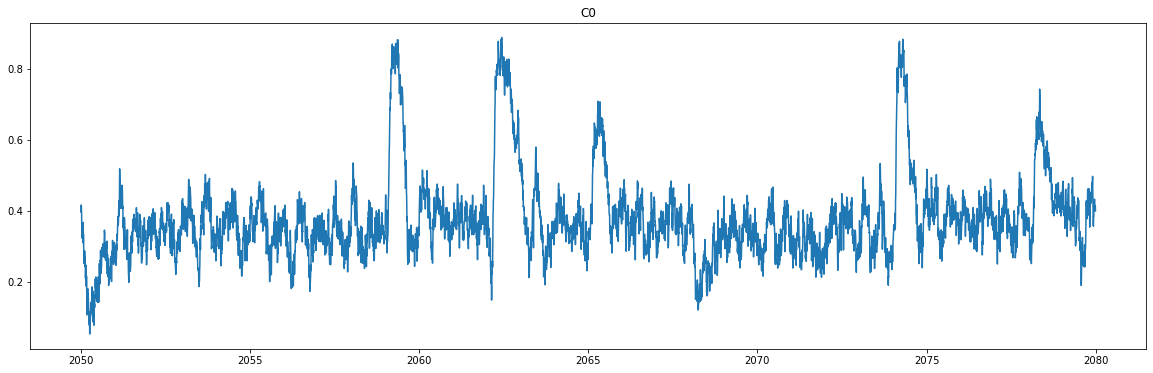

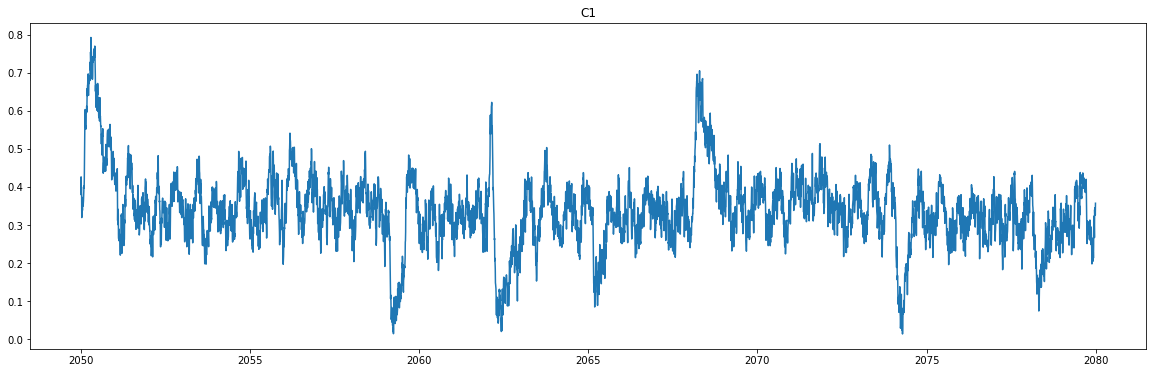

In [35]:
# A
A_fig = plt.figure(figsize=fs)
A_data = np.array(data[A])
plt.plot(times, A_data.transpose())
plt.legend(['A0', 'A1', 'A2', 'A3'])
plt.title('A')
#print(A_data[:,-1])

# L
# L_fig = plt.figure(figsize=fs)
# L_data = np.array(data[L])
# plt.plot(times, L_data.transpose())
# plt.title('L')

# SF, SP
SF_fig = plt.figure(figsize=fs)
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='SF')
plt.plot(times, SP_data.transpose(), label='SP', linewidth=4)
plt.legend()
plt.title('SF, SP')
plt.show()
#print('SF = [%f]' % (SF_data[0,-1]))
#print('SP = [%f]' % (SP_data[0,-1]))


# C0
C0_fig = plt.figure(figsize=fs)
C0_data = np.array(data[C[0]])
plt.plot(times, C0_data.transpose())
#plt.plot(times, data[dc_track[0]], linewidth=3)
plt.title('C0')
#print(C0_data[-1])

# C1
C1_fig = plt.figure(figsize=fs)
C1_data = np.array(data[C[1]])
plt.plot(times, C1_data.transpose())
#plt.plot(times, data[dc_track[1]], linewidth=3)
plt.title('C1')
#print(C1_data[-1])

# M--C0 weights
# W_fig1 = plt.figure(figsize=fs)
# w_track_data = np.array(data[M_C0_track])
# plt.plot(times, w_track_data.transpose())
# plt.legend(['M0-C0', 'M1-C0'])
# plt.title('M--C0 weights')

# # A--M0 weights
# W_fig2 = plt.figure(figsize=fs)
# w_track_data2 = np.array(data[A_M0_track])
# plt.plot(times, w_track_data2.transpose())
# plt.legend(['A0-M0', 'A1-M0', 'A2-M0', 'A3-M0'])
# plt.title('A--M0 weights')


In [36]:
# Testing amount of change in the weights
print("Maximum minus minimum, V:")
print(max(net.units[V[0]].buffer[1:,-1]) - min(net.units[V[0]].buffer[1:,-1]))
print('\n')
print("Maximum minus minimum, X:")
print(max(net.units[X[0]].buffer[1:,-1]) - min(net.units[X[0]].buffer[1:,-1]))

Maximum minus minimum, V:
3.0830354149239976


Maximum minus minimum, X:
2.6258340098259474


In [17]:
net.units[V[0]].buffer[1:,-1]

array([ 2.23075077,  1.62729657,  0.54793297, -0.26101788, -0.72244897,
       -0.7327614 , -0.47520544, -0.13992819,  0.30415071,  1.33349837,
        1.48612147,  1.90309257,  1.27864299,  0.40730095, -0.36086593,
       -0.69345381, -0.67270136, -0.59582756, -0.39502725,  0.33762194,
        0.57844175,  1.26356788,  1.45970136,  1.10888972,  0.1298659 ,
       -0.60028467, -0.73726038, -0.70914873, -0.60174636, -0.16712029,
       -0.02585633,  0.40975041,  0.85030931,  0.86455867,  0.21149888,
       -0.4605546 , -0.69259418, -0.72789848, -0.71142044, -0.44616977,
       -0.54683438, -0.29348286,  0.16827158,  0.29357851,  0.12625448,
       -0.13764282, -0.32539839, -0.49047783, -0.6727178 , -0.6719256 ,
       -0.68022761, -0.5855041 , -0.20805138, -0.10136285,  0.03062219,
        0.46462219,  0.55718554,  0.13583869, -0.34620381, -0.59653906,
       -0.62777702, -0.63554959, -0.566958  , -0.52260355, -0.16682498,
        0.69712937,  1.02366771,  0.6316241 ,  0.09707816, -0.44

In [18]:
net.units[X[0]].buffer[1:,-1]

array([-0.20207821, -0.46505525, -0.41186507,  0.30979305,  0.82734905,
        0.69798456, -0.10141322, -1.0139242 , -1.14226618, -0.57228434,
       -0.3041445 , -0.04447538,  0.13066786,  0.80127578,  1.30270049,
        1.09317213,  0.16100993, -0.90226231, -1.34047136, -0.97985611,
       -0.5573958 , -0.07209133,  0.13103376,  0.60567188,  1.12152663,
        1.18287094,  0.55960622, -0.41459357, -1.13454383, -1.15189681,
       -0.61185743, -0.19185942,  0.05197453,  0.28564211,  0.60455231,
        0.84157335,  0.65497575,  0.00733873, -0.69188257, -0.93652677,
       -0.39063265, -0.12592355,  0.1962234 ,  0.33622296,  0.4157304 ,
        0.64880621,  0.78420866,  0.27183591, -0.32997531, -0.50315804,
       -0.19581853,  0.01580115,  0.37938193,  0.60498585,  0.619949  ,
        0.78625734,  1.01719827,  0.31145325, -0.32539072, -0.29451977,
       -0.35091816, -0.11367061,  0.27359816,  0.66988432,  0.77370747,
        0.69672606,  0.57263127, -0.05359278, -0.5129597 , -0.47

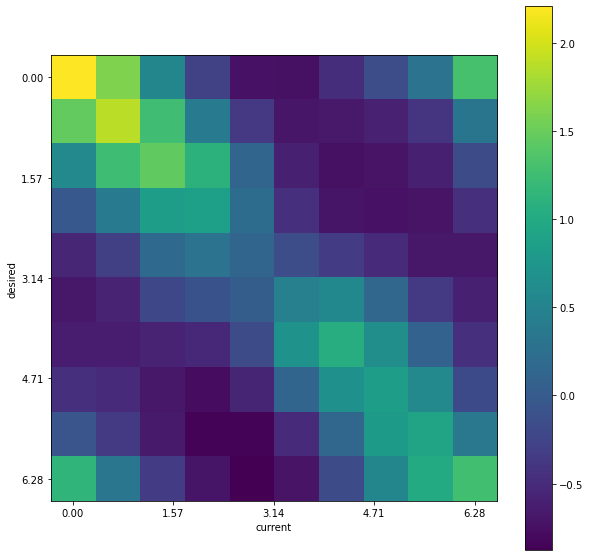

In [37]:
# L__V weights
d_fig = plt.figure(figsize=(10,10))
d_ax = plt.subplot(1,1,1)
cs = d_ax.imshow(net.units[V[0]].buffer[1:,-1].reshape(10,10))
d_fig.colorbar(cs)
d_ax.set_ylabel('desired')
d_ax.set_xlabel('current')
ticks = np.linspace(0.,9,5)
labels = ['{:.2f}'.format(i) for i in np.linspace(0.,2.*np.pi,5)]
d_ax.set_xticks(ticks)
d_ax.set_xticklabels(labels)
d_ax.set_yticks(ticks)
d_ax.set_yticklabels(labels)
plt.show()

Mean input: 0.0022966454319769537


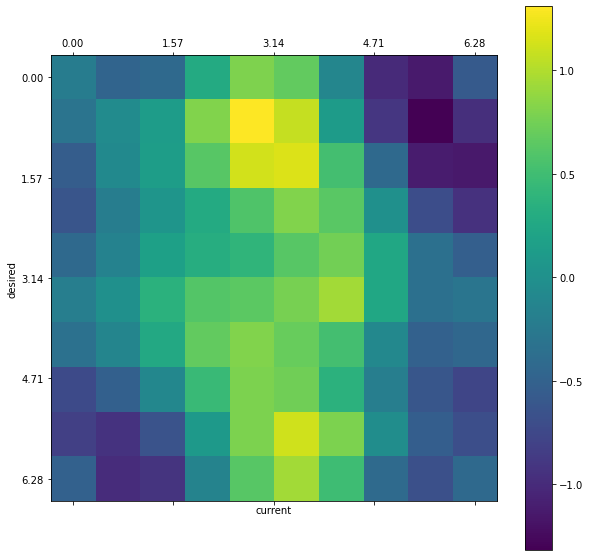

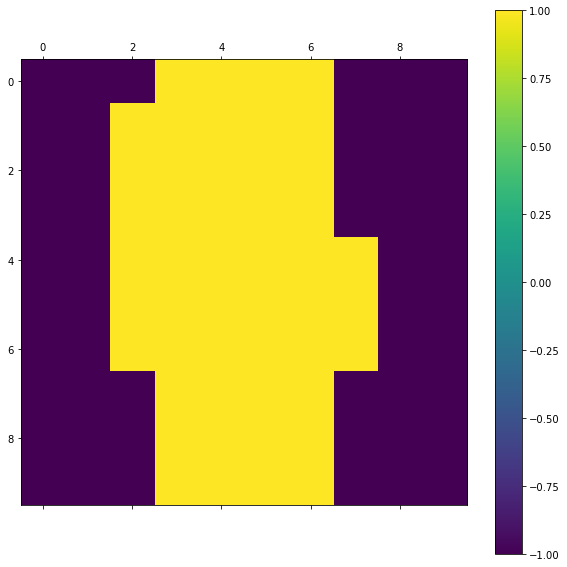

In [38]:
# plot L__X weight matrix
d_fig = plt.figure(figsize=(10,10))
d_ax = plt.subplot(1,1,1)
cs = d_ax.matshow(net.units[X[0]].buffer[1:,-1].reshape(10,10))
d_fig.colorbar(cs)
d_ax.set_ylabel('desired')
d_ax.set_xlabel('current')
ticks = np.linspace(0.,9,5)
labels = ['{:.2f}'.format(i) for i in np.linspace(0.,2.*np.pi,5)]
d_ax.set_xticks(ticks)
d_ax.set_xticklabels(labels)
d_ax.set_yticks(ticks)
d_ax.set_yticklabels(labels)

# plot X output for the inputs at the centers of L units
x = net.units[X[0]]
weights = x.buffer[1:,-1]
x_outs = np.zeros(len(x.centers))
x_inps = np.zeros_like(x_outs)
for idx, angles in enumerate(x.centers):
    d = x.dists(angles)
    s_acts = np.exp(-x.L_wid * d * d)
    I = (s_acts*weights).sum()
    x_outs[idx] = x.f(I)
    x_inps[idx] = I

o_fig = plt.figure(figsize=(10,10))
o_ax = plt.subplot(1,1,1)
ocs = o_ax.matshow(np.sign(x_outs - np.mean(x_outs)).reshape(10,10))
o_fig.colorbar(ocs)
print('Mean input: ' + str(np.mean(x_inps)))


plt.show()

In [30]:
# change the SP function
new_pres_interv = 3.
eps = 0.05
SF_thresh = 0.
# set function for SP0 (angles in [-pi,pi] range)
new_des_angs = np.pi*np.array([0., eps, -eps, 1.-eps, -1.+eps, 0., -1.+eps, 1.-eps, 0., -eps])
new_des_sf = 1./(1. + np.exp(-cfg['SF_slope']*(new_des_angs - SF_thresh)))
start_t = net.sim_time
l = len(new_des_sf)
new_f = lambda t: new_des_sf[int(np.floor((t - start_t)/new_pres_interv))%l]
net.units[SP[0]].set_function(new_f)

# set function for SP1 (angles in [0, 2pi] range)
trans_angs = np.array([a - np.pi if a < np.pi and a > 0. else np.pi + a for a in new_des_angs])
new_alt_sf = 1./(1. + np.exp(-cfg['SF_slope']*(trans_angs - SF_thresh)))
new_alt_f = lambda t: new_alt_sf[int(np.floor((t - start_t)/new_pres_interv))%l]
net.units[SP[1]].set_function(new_alt_f)

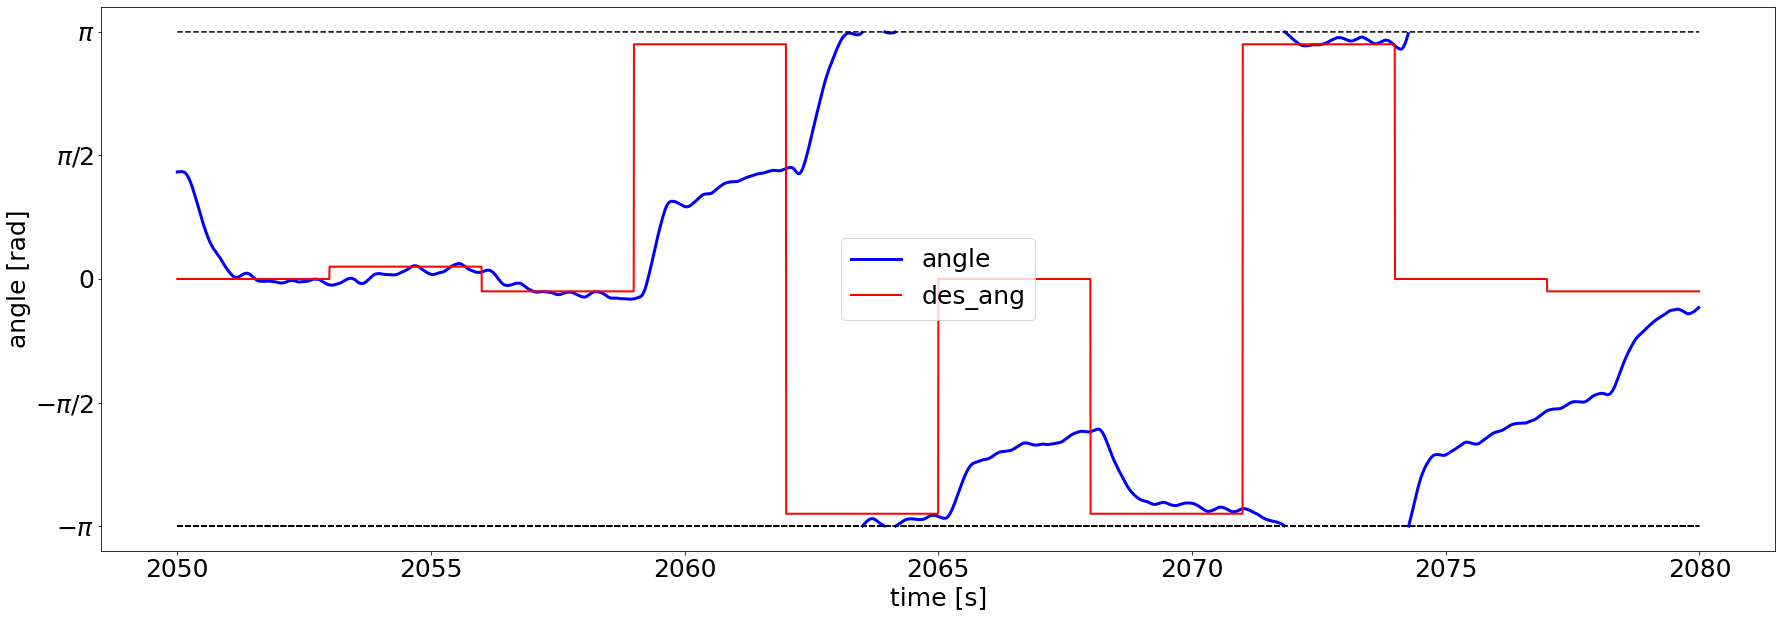

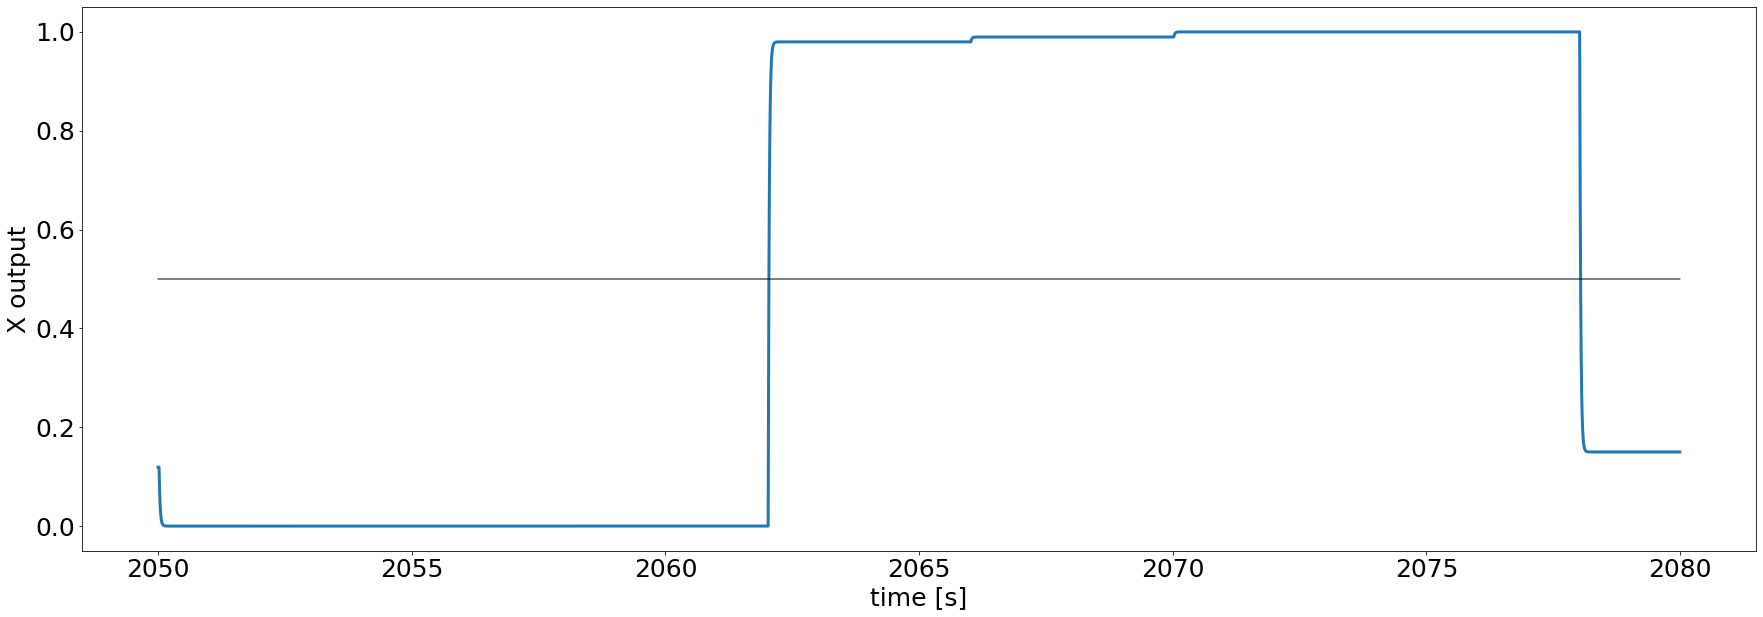

In [39]:
# A figure with more formatting for figure 6 of the paper
# Run only if you have also run a simulation after executing
# the "change the SP function" cell above
new_desa_f = lambda t: new_des_angs[int(np.floor((t - start_t)/new_pres_interv))%l]
new_desa_data = np.array([new_desa_f(t) for t in times])
#new_desa_data = np.array([spf(t) for t in times])

#ang_data = np.mod(plant_data[P][:,0], 2.*np.pi)
ang_data = plant_data[P][:,0]
P_fig2 = plt.figure(figsize=(30,10))
ax = plt.gca()
end_idx = 0
while end_idx < ang_data.size-2:
    init_idx = end_idx
    while abs(ang_data[end_idx] - ang_data[end_idx+1]) < 0.1 and end_idx < ang_data.size-2:
        end_idx += 1
    if init_idx == end_idx and end_idx > 0:
        break
    if init_idx == 0:
        ax.plot(times[init_idx:end_idx], ang_data[init_idx:end_idx], 'b-', linewidth=3, label='angle')
    else:
        ax.plot(times[init_idx:end_idx], ang_data[init_idx:end_idx], 'b-', linewidth=3)
    end_idx += 1

    plt.plot(times, -np.pi*np.ones_like(times), 'k--')
plt.plot(times, np.pi*np.ones_like(times), 'k--')
#plt.plot(times, np.pi/2.*np.ones_like(times), 'r--')
#plt.plot(times, np.zeros_like(times), 'c--')

plt.plot(times, new_desa_data, 'r-', label='des_ang', linewidth=2)

plt.yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['$-\pi$', '$-\pi/2$', '0', '$\pi/2$', '$\pi$'], fontsize=25)
plt.xticks(fontsize=25)
plt.xlabel('time [s]', fontsize=25)
plt.ylabel('angle [rad]', fontsize=25)
plt.legend(fontsize=25)

# X
X_fig = plt.figure(figsize=(30,10))
X_data = np.array(data[X])
plt.plot(times, X_data.transpose(), linewidth=3)
plt.plot(times, 0.5*np.ones(len(times)), 'k', linewidth=1)
#plt.ylim([-0.05,1.05])
#plt.legend(['X'])
#plt.title('X')
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlabel('time [s]', fontsize=25)
plt.ylabel('X output', fontsize=25)

plt.show()

In [ ]:
# Visualize L__X weights
n_plots = 20 # number of plots, each at a different time
n_rows = int(np.ceil(np.sqrt(n_plots)))
n_cols = int(np.ceil(n_plots/n_rows))
t_idxs = [int(i) for i in np.linspace(0, len(times)-1, n_plots)]

L__X_fig, L__X_axs = plt.subplots(n_rows, n_cols, figsize=(fs[0], n_cols*fs[1]))
for i_plot in range(n_plots):
    row, col = np.divmod(i_plot, n_cols)
    ax = L__X_axs[row][col]
    cs = ax.imshow(data[x_track][:,t_idxs[i_plot]].reshape(No2,No2))
    ax.set_title('t='+str(times[t_idxs[i_plot]]))
    
plt.show()

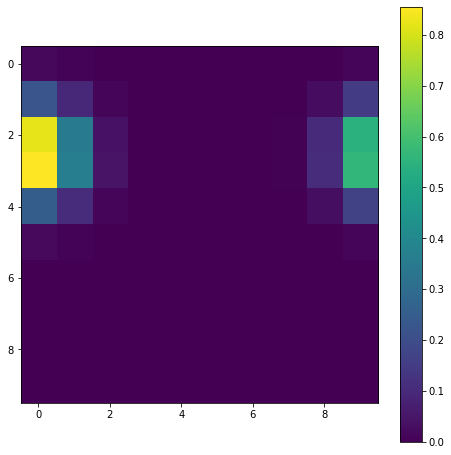

In [23]:
L_out_fig = plt.figure(figsize=(8,8))
axs = plt.subplot(1,1,1)
cs = axs.imshow(net.units[V[0]].L_out_copy.reshape(10,10))
L_out_fig.colorbar(cs)
plt.show()

In [24]:
net.units[V[0]].L_out_copy.sum()

4.999999082493939

In [21]:
# Storing the M__C and A__M connections
M__C_mat = np.zeros((2,2)) # rows are target (C) neurons
for m_idx, m_id in enumerate(M):
    for c_idx, c_id in enumerate(C):
        syn_list = net.syns[c_id]
        for syn in syn_list:
            if syn.preID == m_id:
                M__C_mat[c_idx, m_idx] = syn.w
                break
                
A__M_mat = np.zeros((2,4)) # rows are target (M) neurons
for a_idx, a_id in enumerate(A):
    for m_idx, m_id in enumerate(M):
        syn_list = net.syns[m_id]
        for syn in syn_list:
            if syn.preID == a_id:
                A__M_mat[m_idx, a_idx] = syn.w
                break
print(M__C_mat)
print(A__M_mat)

[[1.68646211e-07 2.08082448e+00]
 [2.08121483e+00 1.56862359e-07]]
[[0.34878441 0.25118419 0.16842648 0.13160544]
 [0.12283056 0.08501225 0.43893599 0.25322015]]


In [7]:
plotty = plotter(net, times, data)

In [12]:
plotty.act_anim(S1+S2+L+R+V, 0.5, interv=10, slider=False)

In [8]:
plotty.conn_anim(L, V)

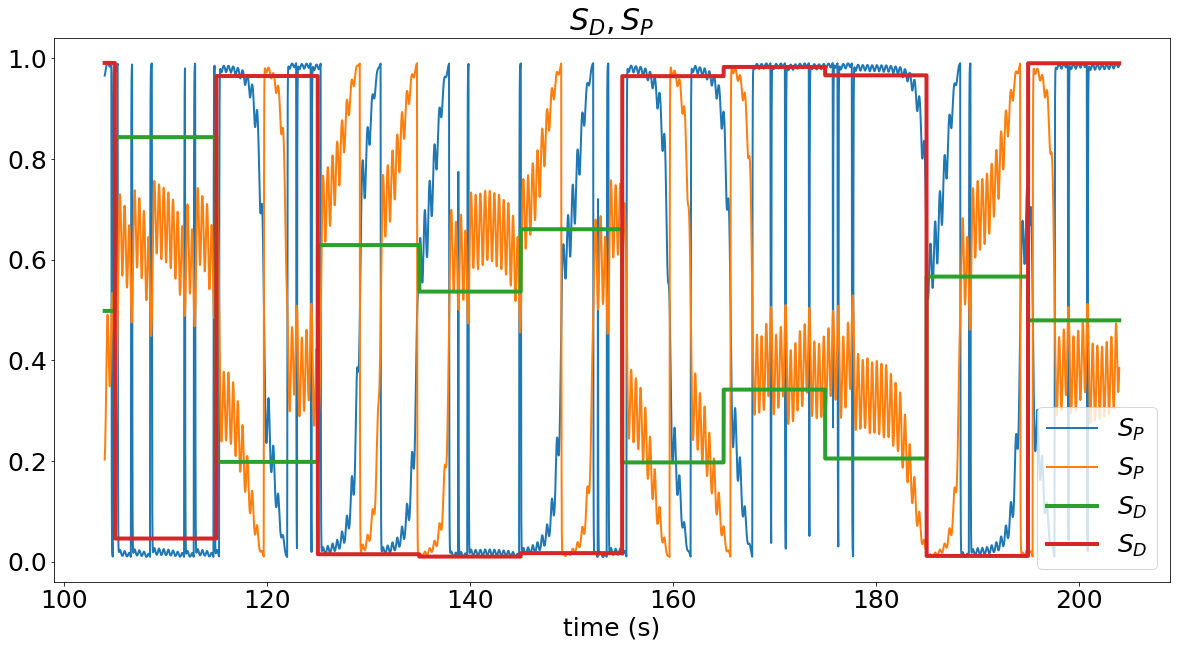

In [18]:
# A figure with more formatting
SPF_fig = plt.figure(figsize=(20,10))
SF_data = np.array(data[SF])
SP_data = np.array(data[SP])
plt.plot(times, SF_data.transpose(), label='$S_P$', linewidth=2)
plt.plot(times, SP_data.transpose(), label='$S_D$', linewidth=4)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=25)
plt.xlabel('time (s)', fontsize =25)
plt.title('$S_D, S_P$', fontsize=30)
plt.show()

In [4]:
# good initial weights

# M__C
# M[0] has the F-D error, so you want C[0] (which exerts positive torque)
# to be driven by M[1] instead, and C[1] to be driven by M[0]
shift = 0
while not net.syns[C[0]][shift].type is synapse_types.rga:
    shift += 1
net.syns[C[0]][shift].w = 0.1
net.syns[C[0]][shift+1].w = 0.8 # C[0] driven by M[1]
net.syns[C[1]][shift].w = 0.8
net.syns[C[1]][shift+1].w = 0.1

# L__X, L__V
scale = 1. # maximum weight value
def dist(c1, c2):
    """ Periodic distance between 2-dim coordinates c1 and c2. 

        Assumes c1 and c2 are inside the box with corners [-0.5, -0.5], [0.5, 0.5].
    """
    x_dist = min(max(c1[0], c2[0]) - min(c1[0], c2[0]),  # "inner" distance
                 0.5-max(c1[0], c2[0]) + (min(c1[0], c2[0])+0.5) ) # "outer" distance
    y_dist = min(max(c1[1], c2[1]) - min(c1[1], c2[1]),  # "inner" distance
                 0.5-max(c1[1], c2[1]) + (min(c1[1], c2[1])+0.5) ) # "outer" distance
    return np.sqrt(x_dist*x_dist + y_dist*y_dist)

#L__V_iw = np.zeros((No2, No2))
j = 0
for i in range(len(L)):  # Setting L__V weights
    u = net.units[L[i]]
    c = u.coordinates
    d = dist(c, [c[1], c[1]])
    Vsyn = net.syns[V[0]][i]
    Xsyn = net.syns[X[0]][i+j]
    while Xsyn.type != synapse_types.diff_rm_hebbian:
        j +=1
        Xsyn = net.syns[X[0]][i+j]
    if Vsyn.preID == u.ID and Xsyn.preID == u.ID:
        a, b = divmod(i, No2)
        Vsyn.w = scale*(.5 - d)
        Xsyn.w = 0.01 if abs(c[1]-c[0]) < 0.5-max(c[1],c[0]) + min(c[1],c[0])+0.5 else .8
    else:
        print("FAILED!!!!!!!")

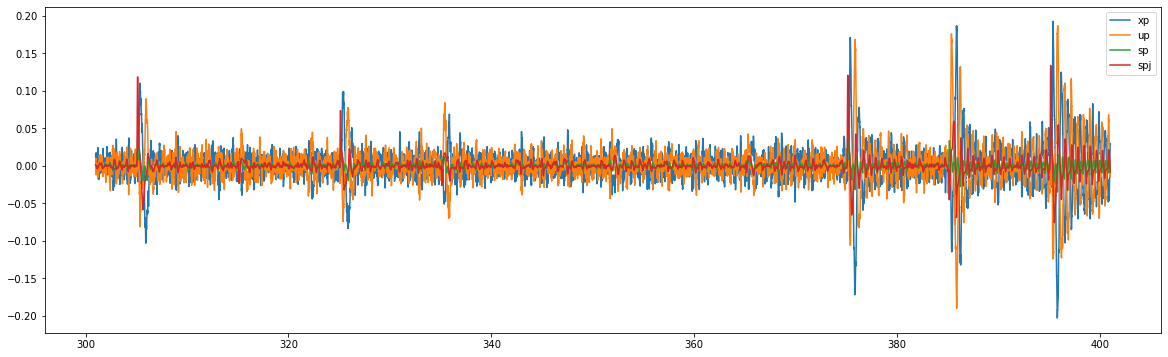

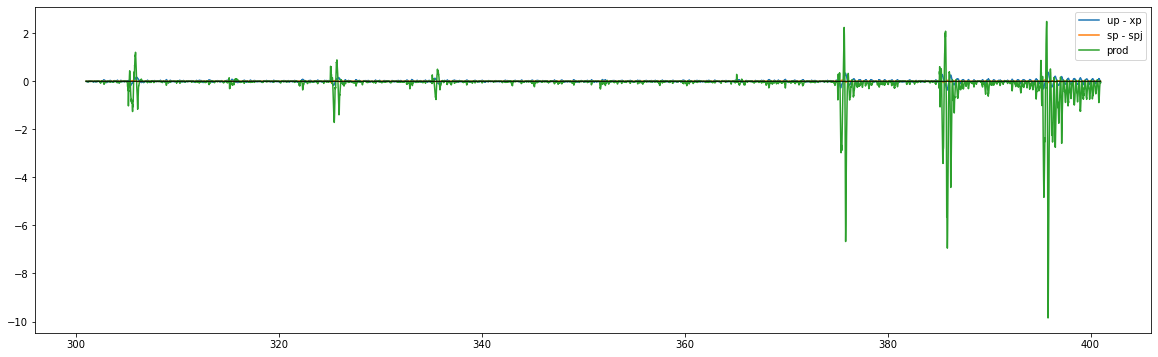

In [20]:
# plot all factors in the M--C0 synaptic plasticity
fs = (20,6)
plastic_fig = plt.figure(figsize=fs)
xp_data = np.array(data[xp_track[0]])
up_data = np.array(data[up_track[0]])
sp_data = np.array(data[sp_track[0]])
spj_data = np.array(data[spj_track[0]])
plt.plot(times, xp_data)
plt.plot(times, up_data)
plt.plot(times, sp_data)
plt.plot(times, spj_data)
plt.legend(['xp', 'up', 'sp', 'spj'])

plastic_fig2 = plt.figure(figsize=fs)
f1 = up_data - xp_data
f2 = sp_data - spj_data
rule = 500. * f1 * f2
plt.plot(times, f1)
plt.plot(times, f2)
plt.plot(times, rule)
plt.plot(times, np.zeros(len(times)), 'k', linewidth=1)
plt.legend(['up - xp', 'sp - spj', 'prod'])
plt.show()

In [11]:
# checking some connections
print("Connections to M0 unit")
for idx, syn in enumerate(net.syns[M[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    #elif pre_id in L:
    #    pre_pop = 'L'
    elif pre_id in M:
        pre_pop = 'M'
    #elif pre_id in V:
    #    pre_pop = 'V'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M0, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to M1 unit")
for idx, syn in enumerate(net.syns[M[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    #elif pre_id in L:
    #    pre_pop = 'L'
    elif pre_id in M:
        pre_pop = 'M'
    #elif pre_id in V:
    #    pre_pop = 'V'
    elif pre_id in SPF:
        pre_pop = 'SPF'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> M1, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))
    
print("Connections to C0 unit")
for idx, syn in enumerate(net.syns[C[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> C0, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))  

print("Connections to C1 unit")
for idx, syn in enumerate(net.syns[C[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    elif pre_id in M:
        pre_pop = 'M'
    elif pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> C1, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))  

    
print("Connections to afferent units")
for idx, syn in enumerate(net.syns[A[2]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in A:
        pre_pop = 'A'
    else:
        pre_pop = 'erroneous'
    if pre_pop == 'P':
        plant_out = str(syn.plant_out)
    else:
        plant_out = 'None'
    print('%d) %s (%d) --> A, w=%f, port=%d, plant_out=%s'%(idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to plant")
for idx, syn in enumerate(net.plants[P].inp_syns[0]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in C:
        pre_pop = 'C'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d, %s) --> P, w=%f'%(idx, pre_pop, pre_id, pre_type, syn.w))
    
print("Connections to MPLEX units")
for idx, syn in enumerate(net.syns[MPLEX[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in X:
        pre_pop = 'X'
    elif pre_id in SF:
        pre_pop = 'SF'
    elif pre_id in SP:
        pre_pop = 'SP'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> MPLEX, w=%f, port=%d'%(idx, pre_pop, pre_id, syn.w, syn.port))  

print("Connections to SF units")
for idx, syn in enumerate(net.syns[SF[1]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id == P and hasattr(syn, 'plant_out'):
        pre_pop = 'P'
    elif pre_id in T:
        pre_pop = 'T'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> SF, w=%f, port=%d, plant_out=%s'%
          (idx, pre_pop, pre_id, syn.w, syn.port, plant_out))

print("Connections to X unit")
for idx, syn in enumerate(net.syns[X[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in V:
        pre_pop = 'V'
    elif pre_id in MPLEX:
        pre_pop = 'MPLEX'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> X, w=%f, port=%d'%(idx, pre_pop, pre_id, syn.w, syn.port))  
    
print("Connections to V unit")
for idx, syn in enumerate(net.syns[V[0]]):
    pre_id = syn.preID
    pre_type = net.units[pre_id].type
    if pre_id in MPLEX:
        pre_pop = 'MPLEX'
    elif pre_id in R:
        pre_pop = 'R'
    else:
        pre_pop = 'erroneous'
    print('%d) %s (%d) --> V, w=%f, port=%d'%(idx, pre_pop, pre_id, syn.w, syn.port))  


Connections to M0 unit
0) A (0) --> M0, w=0.219605, port=2, plant_out=None
1) A (1) --> M0, w=0.248533, port=2, plant_out=None
2) A (2) --> M0, w=0.224219, port=2, plant_out=None
3) A (3) --> M0, w=0.207640, port=2, plant_out=None
4) M (107) --> M0, w=-1.000000, port=3, plant_out=None
5) SPF (155) --> M0, w=1.000000, port=1, plant_out=None
Connections to M1 unit
0) A (0) --> M1, w=0.252435, port=2, plant_out=None
1) A (1) --> M1, w=0.167266, port=2, plant_out=None
2) A (2) --> M1, w=0.215700, port=2, plant_out=None
3) A (3) --> M1, w=0.264603, port=2, plant_out=None
4) M (106) --> M1, w=-1.000000, port=3, plant_out=None
5) SPF (156) --> M1, w=1.000000, port=1, plant_out=None
Connections to C0 unit
0) C (5) --> C0, w=-1.500000, port=1, plant_out=None
1) M (106) --> C0, w=0.014658, port=0, plant_out=None
2) M (107) --> C0, w=2.066072, port=0, plant_out=None
Connections to C1 unit
0) C (4) --> C1, w=-1.500000, port=1, plant_out=None
1) M (106) --> C1, w=2.066016, port=0, plant_out=None
2)

---